In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

mov = (data_df['item_value_0'] + data_df['item_value_1'])/2

data_df['Right Value - Mean Other Value'] = data_df['item_value_2'] - mov
kbins1 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['Right Value - Mean Other Value'] = 2*(kbins1.fit_transform(data_df[['Right Value - Mean Other Value']])-4)

data_df['gaze diff'] = data_df['gaze_2'] - (data_df['gaze_0'] + data_df['gaze_1'])
kbins2 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins2.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - O)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.5)

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(1454, 6) (1468, 6)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    
    sbj_indices = tf.cast(data[:, 4], tf.int32)
    
    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    

    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + ll3 + 0.1**14), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 4], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 3s 3s/step - loss: 14116.2686
Epoch 2/4000
1/1 [==============================] - 0s 8ms/step - loss: 14006.7891
Epoch 3/4000
1/1 [==============================] - 0s 6ms/step - loss: 13929.5410
Epoch 4/4000
1/1 [==============================] - 0s 7ms/step - loss: 13866.0605
Epoch 5/4000
1/1 [==============================] - 0s 8ms/step - loss: 13810.5430
Epoch 6/4000
1/1 [==============================] - 0s 9ms/step - loss: 13760.3037
Epoch 7/4000
1/1 [==============================] - 0s 23ms/step - loss: 13713.8408
Epoch 8/4000
1/1 [==============================] - 0s 9ms/step - loss: 13670.2197
Epoch 9/4000
1/1 [==============================] - 0s 8ms/step - loss: 13628.8223
Epoch 10/4000
1/1 [==============================] - 0s 11ms/step - loss: 13589.2129
Epoch 11/4000
1/1 [==============================] - 0s 9ms/step - loss: 13551.0703
Epoch 12/4000
1/1 [==============================] - 0s 7ms/step - loss: 13514.1572


1/1 [==============================] - 0s 8ms/step - loss: 11398.3418
Epoch 99/4000
1/1 [==============================] - 0s 8ms/step - loss: 11380.4746
Epoch 100/4000
1/1 [==============================] - 0s 9ms/step - loss: 11362.7393
Epoch 101/4000
1/1 [==============================] - 0s 8ms/step - loss: 11345.1348
Epoch 102/4000
1/1 [==============================] - 0s 6ms/step - loss: 11327.6592
Epoch 103/4000
1/1 [==============================] - 0s 10ms/step - loss: 11310.3145
Epoch 104/4000
1/1 [==============================] - 0s 8ms/step - loss: 11293.0977
Epoch 105/4000
1/1 [==============================] - 0s 7ms/step - loss: 11276.0088
Epoch 106/4000
1/1 [==============================] - 0s 7ms/step - loss: 11259.0479
Epoch 107/4000
1/1 [==============================] - 0s 9ms/step - loss: 11242.2109
Epoch 108/4000
1/1 [==============================] - 0s 9ms/step - loss: 11225.5010
Epoch 109/4000
1/1 [==============================] - 0s 8ms/step - loss: 11208.

1/1 [==============================] - 0s 9ms/step - loss: 10165.2061
Epoch 195/4000
1/1 [==============================] - 0s 8ms/step - loss: 10156.1934
Epoch 196/4000
1/1 [==============================] - 0s 8ms/step - loss: 10147.2354
Epoch 197/4000
1/1 [==============================] - 0s 9ms/step - loss: 10138.3281
Epoch 198/4000
1/1 [==============================] - 0s 7ms/step - loss: 10129.4775
Epoch 199/4000
1/1 [==============================] - 0s 7ms/step - loss: 10120.6777
Epoch 200/4000
1/1 [==============================] - 0s 7ms/step - loss: 10111.9287
Epoch 201/4000
1/1 [==============================] - 0s 8ms/step - loss: 10103.2324
Epoch 202/4000
1/1 [==============================] - 0s 6ms/step - loss: 10094.5859
Epoch 203/4000
1/1 [==============================] - 0s 8ms/step - loss: 10085.9912
Epoch 204/4000
1/1 [==============================] - 0s 7ms/step - loss: 10077.4434
Epoch 205/4000
1/1 [==============================] - 0s 10ms/step - loss: 10068

1/1 [==============================] - 0s 8ms/step - loss: 9471.9980
Epoch 292/4000
1/1 [==============================] - 0s 6ms/step - loss: 9466.1758
Epoch 293/4000
1/1 [==============================] - 0s 7ms/step - loss: 9460.3740
Epoch 294/4000
1/1 [==============================] - 0s 7ms/step - loss: 9454.5889
Epoch 295/4000
1/1 [==============================] - 0s 8ms/step - loss: 9448.8223
Epoch 296/4000
1/1 [==============================] - 0s 7ms/step - loss: 9443.0713
Epoch 297/4000
1/1 [==============================] - 0s 9ms/step - loss: 9437.3408
Epoch 298/4000
1/1 [==============================] - 0s 8ms/step - loss: 9431.6270
Epoch 299/4000
1/1 [==============================] - 0s 8ms/step - loss: 9425.9287
Epoch 300/4000
1/1 [==============================] - 0s 11ms/step - loss: 9420.2490
Epoch 301/4000
1/1 [==============================] - 0s 10ms/step - loss: 9414.5859
Epoch 302/4000
1/1 [==============================] - 0s 9ms/step - loss: 9408.9404
Epoch

1/1 [==============================] - 0s 7ms/step - loss: 8972.6514
Epoch 389/4000
1/1 [==============================] - 0s 7ms/step - loss: 8968.0391
Epoch 390/4000
1/1 [==============================] - 0s 6ms/step - loss: 8963.4326
Epoch 391/4000
1/1 [==============================] - 0s 8ms/step - loss: 8958.8359
Epoch 392/4000
1/1 [==============================] - 0s 7ms/step - loss: 8954.2490
Epoch 393/4000
1/1 [==============================] - 0s 7ms/step - loss: 8949.6670
Epoch 394/4000
1/1 [==============================] - 0s 8ms/step - loss: 8945.0967
Epoch 395/4000
1/1 [==============================] - 0s 9ms/step - loss: 8940.5342
Epoch 396/4000
1/1 [==============================] - 0s 8ms/step - loss: 8935.9795
Epoch 397/4000
1/1 [==============================] - 0s 10ms/step - loss: 8931.4326
Epoch 398/4000
1/1 [==============================] - 0s 18ms/step - loss: 8926.8955
Epoch 399/4000
1/1 [==============================] - 0s 24ms/step - loss: 8922.3652
Epoc

1/1 [==============================] - 0s 8ms/step - loss: 8560.4443
Epoch 486/4000
1/1 [==============================] - 0s 7ms/step - loss: 8556.5293
Epoch 487/4000
1/1 [==============================] - 0s 9ms/step - loss: 8552.6211
Epoch 488/4000
1/1 [==============================] - 0s 8ms/step - loss: 8548.7178
Epoch 489/4000
1/1 [==============================] - 0s 8ms/step - loss: 8544.8213
Epoch 490/4000
1/1 [==============================] - 0s 8ms/step - loss: 8540.9326
Epoch 491/4000
1/1 [==============================] - 0s 8ms/step - loss: 8537.0469
Epoch 492/4000
1/1 [==============================] - 0s 7ms/step - loss: 8533.1709
Epoch 493/4000
1/1 [==============================] - 0s 7ms/step - loss: 8529.2979
Epoch 494/4000
1/1 [==============================] - 0s 8ms/step - loss: 8525.4326
Epoch 495/4000
1/1 [==============================] - 0s 7ms/step - loss: 8521.5752
Epoch 496/4000
1/1 [==============================] - 0s 8ms/step - loss: 8517.7207
Epoch 4

1/1 [==============================] - 0s 8ms/step - loss: 8208.7773
Epoch 583/4000
1/1 [==============================] - 0s 7ms/step - loss: 8205.4385
Epoch 584/4000
1/1 [==============================] - 0s 8ms/step - loss: 8202.1045
Epoch 585/4000
1/1 [==============================] - 0s 9ms/step - loss: 8198.7773
Epoch 586/4000
1/1 [==============================] - 0s 7ms/step - loss: 8195.4541
Epoch 587/4000
1/1 [==============================] - 0s 7ms/step - loss: 8192.1377
Epoch 588/4000
1/1 [==============================] - 0s 7ms/step - loss: 8188.8262
Epoch 589/4000
1/1 [==============================] - 0s 7ms/step - loss: 8185.5205
Epoch 590/4000
1/1 [==============================] - 0s 7ms/step - loss: 8182.2207
Epoch 591/4000
1/1 [==============================] - 0s 8ms/step - loss: 8178.9277
Epoch 592/4000
1/1 [==============================] - 0s 7ms/step - loss: 8175.6382
Epoch 593/4000
1/1 [==============================] - 0s 8ms/step - loss: 8172.3550
Epoch 5

1/1 [==============================] - 0s 8ms/step - loss: 7910.4727
Epoch 680/4000
1/1 [==============================] - 0s 8ms/step - loss: 7907.6636
Epoch 681/4000
1/1 [==============================] - 0s 9ms/step - loss: 7904.8599
Epoch 682/4000
1/1 [==============================] - 0s 7ms/step - loss: 7902.0620
Epoch 683/4000
1/1 [==============================] - 0s 8ms/step - loss: 7899.2681
Epoch 684/4000
1/1 [==============================] - 0s 7ms/step - loss: 7896.4810
Epoch 685/4000
1/1 [==============================] - 0s 8ms/step - loss: 7893.6982
Epoch 686/4000
1/1 [==============================] - 0s 7ms/step - loss: 7890.9214
Epoch 687/4000
1/1 [==============================] - 0s 7ms/step - loss: 7888.1494
Epoch 688/4000
1/1 [==============================] - 0s 7ms/step - loss: 7885.3823
Epoch 689/4000
1/1 [==============================] - 0s 14ms/step - loss: 7882.6201
Epoch 690/4000
1/1 [==============================] - 0s 8ms/step - loss: 7879.8647
Epoch 

1/1 [==============================] - 0s 7ms/step - loss: 7661.8638
Epoch 777/4000
1/1 [==============================] - 0s 7ms/step - loss: 7659.5493
Epoch 778/4000
1/1 [==============================] - 0s 7ms/step - loss: 7657.2402
Epoch 779/4000
1/1 [==============================] - 0s 16ms/step - loss: 7654.9346
Epoch 780/4000
1/1 [==============================] - 0s 8ms/step - loss: 7652.6348
Epoch 781/4000
1/1 [==============================] - 0s 8ms/step - loss: 7650.3398
Epoch 782/4000
1/1 [==============================] - 0s 7ms/step - loss: 7648.0503
Epoch 783/4000
1/1 [==============================] - 0s 7ms/step - loss: 7645.7661
Epoch 784/4000
1/1 [==============================] - 0s 8ms/step - loss: 7643.4854
Epoch 785/4000
1/1 [==============================] - 0s 7ms/step - loss: 7641.2124
Epoch 786/4000
1/1 [==============================] - 0s 14ms/step - loss: 7638.9424
Epoch 787/4000
1/1 [==============================] - 0s 53ms/step - loss: 7636.6772
Epoc

1/1 [==============================] - 0s 8ms/step - loss: 7459.7124
Epoch 874/4000
1/1 [==============================] - 0s 8ms/step - loss: 7457.8506
Epoch 875/4000
1/1 [==============================] - 0s 7ms/step - loss: 7455.9937
Epoch 876/4000
1/1 [==============================] - 0s 9ms/step - loss: 7454.1401
Epoch 877/4000
1/1 [==============================] - 0s 8ms/step - loss: 7452.2900
Epoch 878/4000
1/1 [==============================] - 0s 8ms/step - loss: 7450.4443
Epoch 879/4000
1/1 [==============================] - 0s 7ms/step - loss: 7448.6045
Epoch 880/4000
1/1 [==============================] - 0s 7ms/step - loss: 7446.7671
Epoch 881/4000
1/1 [==============================] - 0s 9ms/step - loss: 7444.9355
Epoch 882/4000
1/1 [==============================] - 0s 8ms/step - loss: 7443.1064
Epoch 883/4000
1/1 [==============================] - 0s 7ms/step - loss: 7441.2817
Epoch 884/4000
1/1 [==============================] - 0s 8ms/step - loss: 7439.4624
Epoch 8

1/1 [==============================] - 0s 8ms/step - loss: 7297.7812
Epoch 971/4000
1/1 [==============================] - 0s 7ms/step - loss: 7296.2983
Epoch 972/4000
1/1 [==============================] - 0s 8ms/step - loss: 7294.8198
Epoch 973/4000
1/1 [==============================] - 0s 9ms/step - loss: 7293.3447
Epoch 974/4000
1/1 [==============================] - 0s 7ms/step - loss: 7291.8721
Epoch 975/4000
1/1 [==============================] - 0s 8ms/step - loss: 7290.4043
Epoch 976/4000
1/1 [==============================] - 0s 8ms/step - loss: 7288.9399
Epoch 977/4000
1/1 [==============================] - 0s 9ms/step - loss: 7287.4780
Epoch 978/4000
1/1 [==============================] - 0s 8ms/step - loss: 7286.0190
Epoch 979/4000
1/1 [==============================] - 0s 7ms/step - loss: 7284.5654
Epoch 980/4000
1/1 [==============================] - 0s 7ms/step - loss: 7283.1133
Epoch 981/4000
1/1 [==============================] - 0s 6ms/step - loss: 7281.6665
Epoch 9

1/1 [==============================] - 0s 6ms/step - loss: 7168.3716
Epoch 1067/4000
1/1 [==============================] - 0s 7ms/step - loss: 7167.1143
Epoch 1068/4000
1/1 [==============================] - 0s 8ms/step - loss: 7165.8569
Epoch 1069/4000
1/1 [==============================] - 0s 7ms/step - loss: 7164.5996
Epoch 1070/4000
1/1 [==============================] - 0s 8ms/step - loss: 7163.3433
Epoch 1071/4000
1/1 [==============================] - 0s 10ms/step - loss: 7162.0864
Epoch 1072/4000
1/1 [==============================] - 0s 11ms/step - loss: 7160.8311
Epoch 1073/4000
1/1 [==============================] - 0s 8ms/step - loss: 7159.5752
Epoch 1074/4000
1/1 [==============================] - 0s 9ms/step - loss: 7158.3198
Epoch 1075/4000
1/1 [==============================] - 0s 8ms/step - loss: 7157.0645
Epoch 1076/4000
1/1 [==============================] - 0s 8ms/step - loss: 7155.8081
Epoch 1077/4000
1/1 [==============================] - 0s 10ms/step - loss: 715

1/1 [==============================] - 0s 9ms/step - loss: 7040.0420
Epoch 1163/4000
1/1 [==============================] - 0s 7ms/step - loss: 7038.5205
Epoch 1164/4000
1/1 [==============================] - 0s 8ms/step - loss: 7036.9946
Epoch 1165/4000
1/1 [==============================] - 0s 7ms/step - loss: 7035.4629
Epoch 1166/4000
1/1 [==============================] - 0s 8ms/step - loss: 7033.9258
Epoch 1167/4000
1/1 [==============================] - 0s 9ms/step - loss: 7032.3823
Epoch 1168/4000
1/1 [==============================] - 0s 7ms/step - loss: 7030.8345
Epoch 1169/4000
1/1 [==============================] - 0s 8ms/step - loss: 7029.2808
Epoch 1170/4000
1/1 [==============================] - 0s 7ms/step - loss: 7027.7192
Epoch 1171/4000
1/1 [==============================] - 0s 6ms/step - loss: 7026.1553
Epoch 1172/4000
1/1 [==============================] - 0s 12ms/step - loss: 7024.5840
Epoch 1173/4000
1/1 [==============================] - 0s 9ms/step - loss: 7023.

1/1 [==============================] - 0s 9ms/step - loss: 6875.1851
Epoch 1259/4000
1/1 [==============================] - 0s 7ms/step - loss: 6873.4214
Epoch 1260/4000
1/1 [==============================] - 0s 10ms/step - loss: 6871.6611
Epoch 1261/4000
1/1 [==============================] - 0s 6ms/step - loss: 6869.9053
Epoch 1262/4000
1/1 [==============================] - 0s 8ms/step - loss: 6868.1514
Epoch 1263/4000
1/1 [==============================] - 0s 7ms/step - loss: 6866.4009
Epoch 1264/4000
1/1 [==============================] - 0s 7ms/step - loss: 6864.6553
Epoch 1265/4000
1/1 [==============================] - 0s 7ms/step - loss: 6862.9136
Epoch 1266/4000
1/1 [==============================] - 0s 8ms/step - loss: 6861.1738
Epoch 1267/4000
1/1 [==============================] - 0s 33ms/step - loss: 6859.4399
Epoch 1268/4000
1/1 [==============================] - 0s 32ms/step - loss: 6857.7104
Epoch 1269/4000
1/1 [==============================] - 0s 29ms/step - loss: 68

1/1 [==============================] - 0s 12ms/step - loss: 6731.7285
Epoch 1355/4000
1/1 [==============================] - 0s 9ms/step - loss: 6730.5439
Epoch 1356/4000
1/1 [==============================] - 0s 6ms/step - loss: 6729.3652
Epoch 1357/4000
1/1 [==============================] - 0s 7ms/step - loss: 6728.1919
Epoch 1358/4000
1/1 [==============================] - 0s 7ms/step - loss: 6727.0239
Epoch 1359/4000
1/1 [==============================] - 0s 8ms/step - loss: 6725.8623
Epoch 1360/4000
1/1 [==============================] - 0s 8ms/step - loss: 6724.7065
Epoch 1361/4000
1/1 [==============================] - 0s 8ms/step - loss: 6723.5552
Epoch 1362/4000
1/1 [==============================] - 0s 6ms/step - loss: 6722.4092
Epoch 1363/4000
1/1 [==============================] - 0s 7ms/step - loss: 6721.2681
Epoch 1364/4000
1/1 [==============================] - 0s 7ms/step - loss: 6720.1328
Epoch 1365/4000
1/1 [==============================] - 0s 8ms/step - loss: 6719.

1/1 [==============================] - 0s 8ms/step - loss: 6631.9692
Epoch 1451/4000
1/1 [==============================] - 0s 8ms/step - loss: 6630.9053
Epoch 1452/4000
1/1 [==============================] - 0s 12ms/step - loss: 6629.8354
Epoch 1453/4000
1/1 [==============================] - 0s 26ms/step - loss: 6628.7612
Epoch 1454/4000
1/1 [==============================] - 0s 39ms/step - loss: 6627.6821
Epoch 1455/4000
1/1 [==============================] - 0s 14ms/step - loss: 6626.5972
Epoch 1456/4000
1/1 [==============================] - 0s 13ms/step - loss: 6625.5073
Epoch 1457/4000
1/1 [==============================] - 0s 11ms/step - loss: 6624.4126
Epoch 1458/4000
1/1 [==============================] - 0s 8ms/step - loss: 6623.3120
Epoch 1459/4000
1/1 [==============================] - 0s 13ms/step - loss: 6622.2065
Epoch 1460/4000
1/1 [==============================] - 0s 7ms/step - loss: 6621.0947
Epoch 1461/4000
1/1 [==============================] - 0s 7ms/step - loss:

1/1 [==============================] - 0s 7ms/step - loss: 6487.0342
Epoch 1547/4000
1/1 [==============================] - 0s 7ms/step - loss: 6484.8438
Epoch 1548/4000
1/1 [==============================] - 0s 8ms/step - loss: 6482.6353
Epoch 1549/4000
1/1 [==============================] - 0s 7ms/step - loss: 6480.4087
Epoch 1550/4000
1/1 [==============================] - 0s 7ms/step - loss: 6478.1646
Epoch 1551/4000
1/1 [==============================] - 0s 9ms/step - loss: 6475.9028
Epoch 1552/4000
1/1 [==============================] - 0s 7ms/step - loss: 6473.6230
Epoch 1553/4000
1/1 [==============================] - 0s 7ms/step - loss: 6471.3267
Epoch 1554/4000
1/1 [==============================] - 0s 12ms/step - loss: 6469.0112
Epoch 1555/4000
1/1 [==============================] - 0s 12ms/step - loss: 6466.6787
Epoch 1556/4000
1/1 [==============================] - 0s 6ms/step - loss: 6464.3271
Epoch 1557/4000
1/1 [==============================] - 0s 7ms/step - loss: 6461

1/1 [==============================] - 0s 9ms/step - loss: 6205.0737
Epoch 1643/4000
1/1 [==============================] - 0s 12ms/step - loss: 6201.6646
Epoch 1644/4000
1/1 [==============================] - 0s 7ms/step - loss: 6198.2563
Epoch 1645/4000
1/1 [==============================] - 0s 7ms/step - loss: 6194.8481
Epoch 1646/4000
1/1 [==============================] - 0s 9ms/step - loss: 6191.4424
Epoch 1647/4000
1/1 [==============================] - 0s 19ms/step - loss: 6188.0371
Epoch 1648/4000
1/1 [==============================] - 0s 14ms/step - loss: 6184.6343
Epoch 1649/4000
1/1 [==============================] - 0s 17ms/step - loss: 6181.2344
Epoch 1650/4000
1/1 [==============================] - 0s 9ms/step - loss: 6177.8369
Epoch 1651/4000
1/1 [==============================] - 0s 7ms/step - loss: 6174.4429
Epoch 1652/4000
1/1 [==============================] - 0s 8ms/step - loss: 6171.0518
Epoch 1653/4000
1/1 [==============================] - 0s 9ms/step - loss: 61

1/1 [==============================] - 0s 10ms/step - loss: 5930.3945
Epoch 1738/4000
1/1 [==============================] - 0s 9ms/step - loss: 5928.3540
Epoch 1739/4000
1/1 [==============================] - 0s 8ms/step - loss: 5926.3345
Epoch 1740/4000
1/1 [==============================] - 0s 13ms/step - loss: 5924.3335
Epoch 1741/4000
1/1 [==============================] - 0s 8ms/step - loss: 5922.3506
Epoch 1742/4000
1/1 [==============================] - 0s 7ms/step - loss: 5920.3877
Epoch 1743/4000
1/1 [==============================] - 0s 6ms/step - loss: 5918.4443
Epoch 1744/4000
1/1 [==============================] - 0s 6ms/step - loss: 5916.5200
Epoch 1745/4000
1/1 [==============================] - 0s 6ms/step - loss: 5914.6157
Epoch 1746/4000
1/1 [==============================] - 0s 6ms/step - loss: 5912.7261
Epoch 1747/4000
1/1 [==============================] - 0s 6ms/step - loss: 5910.8599
Epoch 1748/4000
1/1 [==============================] - 0s 8ms/step - loss: 5909

1/1 [==============================] - 0s 6ms/step - loss: 5792.7808
Epoch 1834/4000
1/1 [==============================] - 0s 6ms/step - loss: 5791.7085
Epoch 1835/4000
1/1 [==============================] - 0s 6ms/step - loss: 5790.6426
Epoch 1836/4000
1/1 [==============================] - 0s 6ms/step - loss: 5789.5786
Epoch 1837/4000
1/1 [==============================] - 0s 6ms/step - loss: 5788.5190
Epoch 1838/4000
1/1 [==============================] - 0s 6ms/step - loss: 5787.4609
Epoch 1839/4000
1/1 [==============================] - 0s 6ms/step - loss: 5786.4097
Epoch 1840/4000
1/1 [==============================] - 0s 6ms/step - loss: 5785.3584
Epoch 1841/4000
1/1 [==============================] - 0s 6ms/step - loss: 5784.3149
Epoch 1842/4000
1/1 [==============================] - 0s 6ms/step - loss: 5783.2695
Epoch 1843/4000
1/1 [==============================] - 0s 6ms/step - loss: 5782.2329
Epoch 1844/4000
1/1 [==============================] - 0s 6ms/step - loss: 5781.1

1/1 [==============================] - 0s 7ms/step - loss: 5696.9253
Epoch 1930/4000
1/1 [==============================] - 0s 7ms/step - loss: 5695.9316
Epoch 1931/4000
1/1 [==============================] - 0s 7ms/step - loss: 5694.9429
Epoch 1932/4000
1/1 [==============================] - 0s 8ms/step - loss: 5693.9482
Epoch 1933/4000
1/1 [==============================] - 0s 7ms/step - loss: 5692.9556
Epoch 1934/4000
1/1 [==============================] - 0s 7ms/step - loss: 5691.9600
Epoch 1935/4000
1/1 [==============================] - 0s 6ms/step - loss: 5690.9692
Epoch 1936/4000
1/1 [==============================] - 0s 7ms/step - loss: 5689.9736
Epoch 1937/4000
1/1 [==============================] - 0s 8ms/step - loss: 5688.9814
Epoch 1938/4000
1/1 [==============================] - 0s 7ms/step - loss: 5687.9858
Epoch 1939/4000
1/1 [==============================] - 0s 7ms/step - loss: 5686.9922
Epoch 1940/4000
1/1 [==============================] - 0s 8ms/step - loss: 5685.9

1/1 [==============================] - 0s 14ms/step - loss: 5602.0093
Epoch 2026/4000
1/1 [==============================] - 0s 6ms/step - loss: 5601.0542
Epoch 2027/4000
1/1 [==============================] - 0s 8ms/step - loss: 5600.1113
Epoch 2028/4000
1/1 [==============================] - 0s 7ms/step - loss: 5599.1621
Epoch 2029/4000
1/1 [==============================] - 0s 12ms/step - loss: 5598.2271
Epoch 2030/4000
1/1 [==============================] - 0s 11ms/step - loss: 5597.2788
Epoch 2031/4000
1/1 [==============================] - 0s 11ms/step - loss: 5596.3428
Epoch 2032/4000
1/1 [==============================] - 0s 10ms/step - loss: 5595.4038
Epoch 2033/4000
1/1 [==============================] - 0s 7ms/step - loss: 5594.4717
Epoch 2034/4000
1/1 [==============================] - 0s 7ms/step - loss: 5593.5308
Epoch 2035/4000
1/1 [==============================] - 0s 8ms/step - loss: 5592.6064
Epoch 2036/4000
1/1 [==============================] - 0s 7ms/step - loss: 5

1/1 [==============================] - 0s 8ms/step - loss: 5520.1812
Epoch 2122/4000
1/1 [==============================] - 0s 6ms/step - loss: 5519.4136
Epoch 2123/4000
1/1 [==============================] - 0s 8ms/step - loss: 5518.6455
Epoch 2124/4000
1/1 [==============================] - 0s 7ms/step - loss: 5517.9004
Epoch 2125/4000
1/1 [==============================] - 0s 8ms/step - loss: 5517.1460
Epoch 2126/4000
1/1 [==============================] - 0s 5ms/step - loss: 5516.3945
Epoch 2127/4000
1/1 [==============================] - 0s 9ms/step - loss: 5515.6514
Epoch 2128/4000
1/1 [==============================] - 0s 10ms/step - loss: 5514.8877
Epoch 2129/4000
1/1 [==============================] - 0s 8ms/step - loss: 5514.1431
Epoch 2130/4000
1/1 [==============================] - 0s 7ms/step - loss: 5513.3760
Epoch 2131/4000
1/1 [==============================] - 0s 7ms/step - loss: 5512.6392
Epoch 2132/4000
1/1 [==============================] - 0s 7ms/step - loss: 5511.

1/1 [==============================] - 0s 9ms/step - loss: 5452.6123
Epoch 2218/4000
1/1 [==============================] - 0s 8ms/step - loss: 5451.9507
Epoch 2219/4000
1/1 [==============================] - 0s 6ms/step - loss: 5451.2563
Epoch 2220/4000
1/1 [==============================] - 0s 8ms/step - loss: 5450.5737
Epoch 2221/4000
1/1 [==============================] - 0s 8ms/step - loss: 5449.9126
Epoch 2222/4000
1/1 [==============================] - 0s 7ms/step - loss: 5449.2485
Epoch 2223/4000
1/1 [==============================] - 0s 7ms/step - loss: 5448.6011
Epoch 2224/4000
1/1 [==============================] - 0s 6ms/step - loss: 5447.8647
Epoch 2225/4000
1/1 [==============================] - 0s 6ms/step - loss: 5447.2964
Epoch 2226/4000
1/1 [==============================] - 0s 7ms/step - loss: 5446.6323
Epoch 2227/4000
1/1 [==============================] - 0s 7ms/step - loss: 5445.9272
Epoch 2228/4000
1/1 [==============================] - 0s 8ms/step - loss: 5445.2

1/1 [==============================] - 0s 6ms/step - loss: 5389.5596
Epoch 2314/4000
1/1 [==============================] - 0s 6ms/step - loss: 5388.9541
Epoch 2315/4000
1/1 [==============================] - 0s 6ms/step - loss: 5388.2744
Epoch 2316/4000
1/1 [==============================] - 0s 6ms/step - loss: 5387.6938
Epoch 2317/4000
1/1 [==============================] - 0s 7ms/step - loss: 5386.9321
Epoch 2318/4000
1/1 [==============================] - 0s 7ms/step - loss: 5386.2524
Epoch 2319/4000
1/1 [==============================] - 0s 10ms/step - loss: 5385.6450
Epoch 2320/4000
1/1 [==============================] - 0s 8ms/step - loss: 5385.0640
Epoch 2321/4000
1/1 [==============================] - 0s 7ms/step - loss: 5384.3237
Epoch 2322/4000
1/1 [==============================] - 0s 6ms/step - loss: 5383.7202
Epoch 2323/4000
1/1 [==============================] - 0s 6ms/step - loss: 5382.9883
Epoch 2324/4000
1/1 [==============================] - 0s 6ms/step - loss: 5382.

1/1 [==============================] - 0s 7ms/step - loss: 5327.1587
Epoch 2410/4000
1/1 [==============================] - 0s 6ms/step - loss: 5326.4087
Epoch 2411/4000
1/1 [==============================] - 0s 10ms/step - loss: 5325.6831
Epoch 2412/4000
1/1 [==============================] - 0s 7ms/step - loss: 5325.0073
Epoch 2413/4000
1/1 [==============================] - 0s 19ms/step - loss: 5324.3579
Epoch 2414/4000
1/1 [==============================] - 0s 29ms/step - loss: 5323.6377
Epoch 2415/4000
1/1 [==============================] - 0s 7ms/step - loss: 5323.1489
Epoch 2416/4000
1/1 [==============================] - 0s 7ms/step - loss: 5322.5273
Epoch 2417/4000
1/1 [==============================] - 0s 10ms/step - loss: 5321.7554
Epoch 2418/4000
1/1 [==============================] - 0s 6ms/step - loss: 5321.0610
Epoch 2419/4000
1/1 [==============================] - 0s 17ms/step - loss: 5320.6802
Epoch 2420/4000
1/1 [==============================] - 0s 14ms/step - loss: 

1/1 [==============================] - 0s 7ms/step - loss: 5264.5420
Epoch 2506/4000
1/1 [==============================] - 0s 7ms/step - loss: 5263.8169
Epoch 2507/4000
1/1 [==============================] - 0s 8ms/step - loss: 5263.1758
Epoch 2508/4000
1/1 [==============================] - 0s 7ms/step - loss: 5262.5508
Epoch 2509/4000
1/1 [==============================] - 0s 8ms/step - loss: 5262.2993
Epoch 2510/4000
1/1 [==============================] - 0s 7ms/step - loss: 5261.5005
Epoch 2511/4000
1/1 [==============================] - 0s 7ms/step - loss: 5260.8096
Epoch 2512/4000
1/1 [==============================] - 0s 10ms/step - loss: 5260.1670
Epoch 2513/4000
1/1 [==============================] - 0s 8ms/step - loss: 5259.3721
Epoch 2514/4000
1/1 [==============================] - 0s 8ms/step - loss: 5258.8096
Epoch 2515/4000
1/1 [==============================] - 0s 9ms/step - loss: 5258.1777
Epoch 2516/4000
1/1 [==============================] - 0s 8ms/step - loss: 5257.

1/1 [==============================] - 0s 7ms/step - loss: 5202.6323
Epoch 2602/4000
1/1 [==============================] - 0s 12ms/step - loss: 5202.3438
Epoch 2603/4000
1/1 [==============================] - 0s 40ms/step - loss: 5201.6465
Epoch 2604/4000
1/1 [==============================] - 0s 69ms/step - loss: 5200.9795
Epoch 2605/4000
1/1 [==============================] - 0s 8ms/step - loss: 5200.2490
Epoch 2606/4000
1/1 [==============================] - 0s 8ms/step - loss: 5199.9473
Epoch 2607/4000
1/1 [==============================] - 0s 7ms/step - loss: 5199.2051
Epoch 2608/4000
1/1 [==============================] - 0s 8ms/step - loss: 5198.4526
Epoch 2609/4000
1/1 [==============================] - 0s 12ms/step - loss: 5197.8223
Epoch 2610/4000
1/1 [==============================] - 0s 7ms/step - loss: 5197.2607
Epoch 2611/4000
1/1 [==============================] - 0s 8ms/step - loss: 5196.6201
Epoch 2612/4000
1/1 [==============================] - 0s 7ms/step - loss: 51

1/1 [==============================] - 0s 7ms/step - loss: 5141.5615
Epoch 2698/4000
1/1 [==============================] - 0s 7ms/step - loss: 5140.6553
Epoch 2699/4000
1/1 [==============================] - 0s 8ms/step - loss: 5140.3018
Epoch 2700/4000
1/1 [==============================] - 0s 8ms/step - loss: 5139.4849
Epoch 2701/4000
1/1 [==============================] - 0s 6ms/step - loss: 5139.1514
Epoch 2702/4000
1/1 [==============================] - 0s 7ms/step - loss: 5137.9985
Epoch 2703/4000
1/1 [==============================] - 0s 7ms/step - loss: 5137.8286
Epoch 2704/4000
1/1 [==============================] - 0s 6ms/step - loss: 5136.9497
Epoch 2705/4000
1/1 [==============================] - 0s 6ms/step - loss: 5136.1050
Epoch 2706/4000
1/1 [==============================] - 0s 6ms/step - loss: 5135.6636
Epoch 2707/4000
1/1 [==============================] - 0s 7ms/step - loss: 5134.6602
Epoch 2708/4000
1/1 [==============================] - 0s 7ms/step - loss: 5134.1

1/1 [==============================] - 0s 6ms/step - loss: 5078.0483
Epoch 2794/4000
1/1 [==============================] - 0s 7ms/step - loss: 5077.5117
Epoch 2795/4000
1/1 [==============================] - 0s 7ms/step - loss: 5076.2559
Epoch 2796/4000
1/1 [==============================] - 0s 8ms/step - loss: 5075.4600
Epoch 2797/4000
1/1 [==============================] - 0s 7ms/step - loss: 5074.9160
Epoch 2798/4000
1/1 [==============================] - 0s 7ms/step - loss: 5074.1172
Epoch 2799/4000
1/1 [==============================] - 0s 9ms/step - loss: 5073.8130
Epoch 2800/4000
1/1 [==============================] - 0s 7ms/step - loss: 5073.0688
Epoch 2801/4000
1/1 [==============================] - 0s 7ms/step - loss: 5072.3359
Epoch 2802/4000
1/1 [==============================] - 0s 6ms/step - loss: 5071.7695
Epoch 2803/4000
1/1 [==============================] - 0s 7ms/step - loss: 5070.8740
Epoch 2804/4000
1/1 [==============================] - 0s 7ms/step - loss: 5070.1

1/1 [==============================] - 0s 7ms/step - loss: 5007.2695
Epoch 2890/4000
1/1 [==============================] - 0s 11ms/step - loss: 5006.6816
Epoch 2891/4000
1/1 [==============================] - 0s 10ms/step - loss: 5006.1240
Epoch 2892/4000
1/1 [==============================] - 0s 12ms/step - loss: 5005.2808
Epoch 2893/4000
1/1 [==============================] - 0s 10ms/step - loss: 5004.3921
Epoch 2894/4000
1/1 [==============================] - 0s 10ms/step - loss: 5003.5991
Epoch 2895/4000
1/1 [==============================] - 0s 10ms/step - loss: 5002.8701
Epoch 2896/4000
1/1 [==============================] - 0s 12ms/step - loss: 5001.9893
Epoch 2897/4000
1/1 [==============================] - 0s 12ms/step - loss: 5000.8120
Epoch 2898/4000
1/1 [==============================] - 0s 9ms/step - loss: 5000.4512
Epoch 2899/4000
1/1 [==============================] - 0s 8ms/step - loss: 4998.8179
Epoch 2900/4000
1/1 [==============================] - 0s 7ms/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 4925.9990
Epoch 2986/4000
1/1 [==============================] - 0s 8ms/step - loss: 4925.5122
Epoch 2987/4000
1/1 [==============================] - 0s 6ms/step - loss: 4924.7378
Epoch 2988/4000
1/1 [==============================] - 0s 7ms/step - loss: 4924.0796
Epoch 2989/4000
1/1 [==============================] - 0s 7ms/step - loss: 4923.6177
Epoch 2990/4000
1/1 [==============================] - 0s 7ms/step - loss: 4922.2759
Epoch 2991/4000
1/1 [==============================] - 0s 8ms/step - loss: 4921.5605
Epoch 2992/4000
1/1 [==============================] - 0s 7ms/step - loss: 4920.1943
Epoch 2993/4000
1/1 [==============================] - 0s 7ms/step - loss: 4919.3530
Epoch 2994/4000
1/1 [==============================] - 0s 9ms/step - loss: 4918.6533
Epoch 2995/4000
1/1 [==============================] - 0s 7ms/step - loss: 4917.3086
Epoch 2996/4000
1/1 [==============================] - 0s 8ms/step - loss: 4916.7

1/1 [==============================] - 0s 28ms/step - loss: 4843.1558
Epoch 3082/4000
1/1 [==============================] - 0s 28ms/step - loss: 4843.0874
Epoch 3083/4000
1/1 [==============================] - 0s 13ms/step - loss: 4842.3457
Epoch 3084/4000
1/1 [==============================] - 0s 7ms/step - loss: 4841.4585
Epoch 3085/4000
1/1 [==============================] - 0s 7ms/step - loss: 4840.2139
Epoch 3086/4000
1/1 [==============================] - 0s 6ms/step - loss: 4840.0684
Epoch 3087/4000
1/1 [==============================] - 0s 6ms/step - loss: 4839.7285
Epoch 3088/4000
1/1 [==============================] - 0s 8ms/step - loss: 4837.4614
Epoch 3089/4000
1/1 [==============================] - 0s 7ms/step - loss: 4837.4111
Epoch 3090/4000
1/1 [==============================] - 0s 8ms/step - loss: 4836.5400
Epoch 3091/4000
1/1 [==============================] - 0s 7ms/step - loss: 4836.1108
Epoch 3092/4000
1/1 [==============================] - 0s 7ms/step - loss: 483

1/1 [==============================] - 0s 6ms/step - loss: 4770.9214
Epoch 3178/4000
1/1 [==============================] - 0s 7ms/step - loss: 4770.0894
Epoch 3179/4000
1/1 [==============================] - 0s 8ms/step - loss: 4768.7446
Epoch 3180/4000
1/1 [==============================] - 0s 7ms/step - loss: 4768.9990
Epoch 3181/4000
1/1 [==============================] - 0s 6ms/step - loss: 4768.6831
Epoch 3182/4000
1/1 [==============================] - 0s 6ms/step - loss: 4767.3716
Epoch 3183/4000
1/1 [==============================] - 0s 6ms/step - loss: 4766.5288
Epoch 3184/4000
1/1 [==============================] - 0s 7ms/step - loss: 4765.6426
Epoch 3185/4000
1/1 [==============================] - 0s 8ms/step - loss: 4765.4053
Epoch 3186/4000
1/1 [==============================] - 0s 7ms/step - loss: 4764.3599
Epoch 3187/4000
1/1 [==============================] - 0s 8ms/step - loss: 4763.8066
Epoch 3188/4000
1/1 [==============================] - 0s 7ms/step - loss: 4763.4

1/1 [==============================] - 0s 7ms/step - loss: 4707.0059
Epoch 3274/4000
1/1 [==============================] - 0s 8ms/step - loss: 4706.0850
Epoch 3275/4000
1/1 [==============================] - 0s 6ms/step - loss: 4706.1118
Epoch 3276/4000
1/1 [==============================] - 0s 9ms/step - loss: 4704.0444
Epoch 3277/4000
1/1 [==============================] - 0s 6ms/step - loss: 4704.6699
Epoch 3278/4000
1/1 [==============================] - 0s 6ms/step - loss: 4703.6924
Epoch 3279/4000
1/1 [==============================] - 0s 6ms/step - loss: 4703.3970
Epoch 3280/4000
1/1 [==============================] - 0s 7ms/step - loss: 4701.9546
Epoch 3281/4000
1/1 [==============================] - 0s 6ms/step - loss: 4702.9624
Epoch 3282/4000
1/1 [==============================] - 0s 7ms/step - loss: 4701.2295
Epoch 3283/4000
1/1 [==============================] - 0s 10ms/step - loss: 4700.9131
Epoch 3284/4000
1/1 [==============================] - 0s 10ms/step - loss: 4700

1/1 [==============================] - 0s 6ms/step - loss: 4659.3955
Epoch 3370/4000
1/1 [==============================] - 0s 5ms/step - loss: 4656.6650
Epoch 3371/4000
1/1 [==============================] - 0s 7ms/step - loss: 4662.3813
Epoch 3372/4000
1/1 [==============================] - 0s 7ms/step - loss: 4658.1494
Epoch 3373/4000
1/1 [==============================] - 0s 5ms/step - loss: 4655.7920
Epoch 3374/4000
1/1 [==============================] - 0s 5ms/step - loss: 4655.9541
Epoch 3375/4000
1/1 [==============================] - 0s 7ms/step - loss: 4654.5356
Epoch 3376/4000
1/1 [==============================] - 0s 6ms/step - loss: 4654.8706
Epoch 3377/4000
1/1 [==============================] - 0s 6ms/step - loss: 4653.9419
Epoch 3378/4000
1/1 [==============================] - 0s 6ms/step - loss: 4655.7988
Epoch 3379/4000
1/1 [==============================] - 0s 6ms/step - loss: 4653.5288
Epoch 3380/4000
1/1 [==============================] - 0s 7ms/step - loss: 4654.4

1/1 [==============================] - 0s 7ms/step - loss: 4622.2109
Epoch 3466/4000
1/1 [==============================] - 0s 6ms/step - loss: 4621.2358
Epoch 3467/4000
1/1 [==============================] - 0s 5ms/step - loss: 4622.3018
Epoch 3468/4000
1/1 [==============================] - 0s 6ms/step - loss: 4621.4727
Epoch 3469/4000
1/1 [==============================] - 0s 8ms/step - loss: 4621.7393
Epoch 3470/4000
1/1 [==============================] - 0s 7ms/step - loss: 4621.2168
Epoch 3471/4000
1/1 [==============================] - 0s 7ms/step - loss: 4620.2368
Epoch 3472/4000
1/1 [==============================] - 0s 6ms/step - loss: 4620.8467
Epoch 3473/4000
1/1 [==============================] - 0s 6ms/step - loss: 4620.9487
Epoch 3474/4000
1/1 [==============================] - 0s 6ms/step - loss: 4621.2446
Epoch 3475/4000
1/1 [==============================] - 0s 7ms/step - loss: 4620.8320
Epoch 3476/4000
1/1 [==============================] - 0s 6ms/step - loss: 4619.6

1/1 [==============================] - 0s 10ms/step - loss: 4600.2290
Epoch 3562/4000
1/1 [==============================] - 0s 15ms/step - loss: 4600.2480
Epoch 3563/4000
1/1 [==============================] - 0s 12ms/step - loss: 4597.6445
Epoch 3564/4000
1/1 [==============================] - 0s 10ms/step - loss: 4598.8955
Epoch 3565/4000
1/1 [==============================] - 0s 7ms/step - loss: 4598.8994
Epoch 3566/4000
1/1 [==============================] - 0s 14ms/step - loss: 4599.0933
Epoch 3567/4000
1/1 [==============================] - 0s 23ms/step - loss: 4600.2739
Epoch 3568/4000
1/1 [==============================] - 0s 9ms/step - loss: 4600.2290
Epoch 3569/4000
1/1 [==============================] - 0s 8ms/step - loss: 4598.1602
Epoch 3570/4000
1/1 [==============================] - 0s 9ms/step - loss: 4598.2988
Epoch 3571/4000
1/1 [==============================] - 0s 10ms/step - loss: 4598.7124
Epoch 3572/4000
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 13ms/step - loss: 4583.1396
Epoch 3658/4000
1/1 [==============================] - 0s 11ms/step - loss: 4582.5415
Epoch 3659/4000
1/1 [==============================] - 0s 10ms/step - loss: 4583.4385
Epoch 3660/4000
1/1 [==============================] - 0s 11ms/step - loss: 4580.9751
Epoch 3661/4000
1/1 [==============================] - 0s 10ms/step - loss: 4581.7231
Epoch 3662/4000
1/1 [==============================] - 0s 10ms/step - loss: 4582.0552
Epoch 3663/4000
1/1 [==============================] - 0s 10ms/step - loss: 4580.7065
Epoch 3664/4000
1/1 [==============================] - 0s 10ms/step - loss: 4580.6201
Epoch 3665/4000
1/1 [==============================] - 0s 11ms/step - loss: 4582.5405
Epoch 3666/4000
1/1 [==============================] - 0s 7ms/step - loss: 4581.9722
Epoch 3667/4000
1/1 [==============================] - 0s 7ms/step - loss: 4580.0859
Epoch 3668/4000
1/1 [==============================] - 0s 8ms/step - los

1/1 [==============================] - 0s 6ms/step - loss: 4567.9839
Epoch 3754/4000
1/1 [==============================] - 0s 7ms/step - loss: 4567.4150
Epoch 3755/4000
1/1 [==============================] - 0s 7ms/step - loss: 4566.0410
Epoch 3756/4000
1/1 [==============================] - 0s 6ms/step - loss: 4566.2544
Epoch 3757/4000
1/1 [==============================] - 0s 8ms/step - loss: 4567.5332
Epoch 3758/4000
1/1 [==============================] - 0s 9ms/step - loss: 4565.9448
Epoch 3759/4000
1/1 [==============================] - 0s 8ms/step - loss: 4563.8716
Epoch 3760/4000
1/1 [==============================] - 0s 10ms/step - loss: 4563.2334
Epoch 3761/4000
1/1 [==============================] - 0s 7ms/step - loss: 4564.6479
Epoch 3762/4000
1/1 [==============================] - 0s 7ms/step - loss: 4563.4048
Epoch 3763/4000
1/1 [==============================] - 0s 7ms/step - loss: 4564.4648
Epoch 3764/4000
1/1 [==============================] - 0s 7ms/step - loss: 4564.

1/1 [==============================] - 0s 7ms/step - loss: 4555.8892
Epoch 3850/4000
1/1 [==============================] - 0s 7ms/step - loss: 4555.5537
Epoch 3851/4000
1/1 [==============================] - 0s 7ms/step - loss: 4557.0610
Epoch 3852/4000
1/1 [==============================] - 0s 6ms/step - loss: 4557.5215
Epoch 3853/4000
1/1 [==============================] - 0s 6ms/step - loss: 4554.6279
Epoch 3854/4000
1/1 [==============================] - 0s 7ms/step - loss: 4552.8013
Epoch 3855/4000
1/1 [==============================] - 0s 7ms/step - loss: 4554.4380
Epoch 3856/4000
1/1 [==============================] - 0s 7ms/step - loss: 4556.5312
Epoch 3857/4000
1/1 [==============================] - 0s 7ms/step - loss: 4554.6431
Epoch 3858/4000
1/1 [==============================] - 0s 8ms/step - loss: 4553.2681
Epoch 3859/4000
1/1 [==============================] - 0s 12ms/step - loss: 4553.3120
Epoch 3860/4000
1/1 [==============================] - 0s 7ms/step - loss: 4555.

1/1 [==============================] - 0s 11ms/step - loss: 4545.2637
Epoch 3946/4000
1/1 [==============================] - 0s 9ms/step - loss: 4545.5562
Epoch 3947/4000
1/1 [==============================] - 0s 41ms/step - loss: 4544.8955
Epoch 3948/4000
1/1 [==============================] - 0s 24ms/step - loss: 4546.1411
Epoch 3949/4000
1/1 [==============================] - 0s 11ms/step - loss: 4544.4604
Epoch 3950/4000
1/1 [==============================] - 0s 10ms/step - loss: 4544.5811
Epoch 3951/4000
1/1 [==============================] - 0s 9ms/step - loss: 4543.2188
Epoch 3952/4000
1/1 [==============================] - 0s 8ms/step - loss: 4546.5991
Epoch 3953/4000
1/1 [==============================] - 0s 8ms/step - loss: 4547.8511
Epoch 3954/4000
1/1 [==============================] - 0s 7ms/step - loss: 4545.5039
Epoch 3955/4000
1/1 [==============================] - 0s 9ms/step - loss: 4550.7910
Epoch 3956/4000
1/1 [==============================] - 0s 11ms/step - loss: 

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

46/46 [==============================] - 0s 2ms/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]

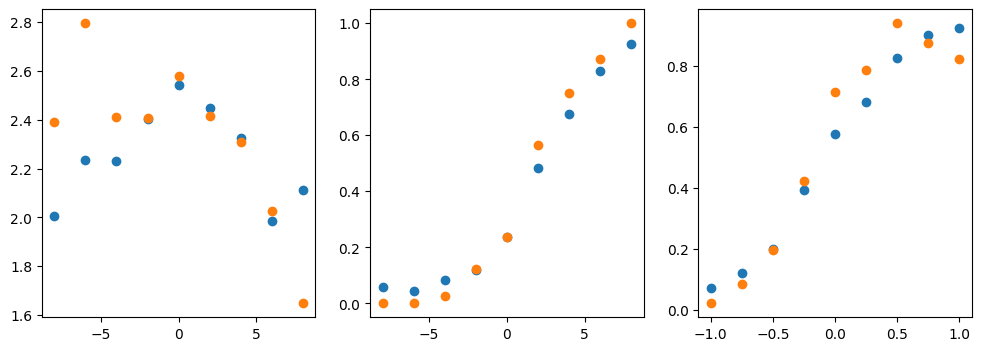

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['choice_2'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - O)')['Dwell Time Advantage (R - O)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - O)')['choice_2'].mean());

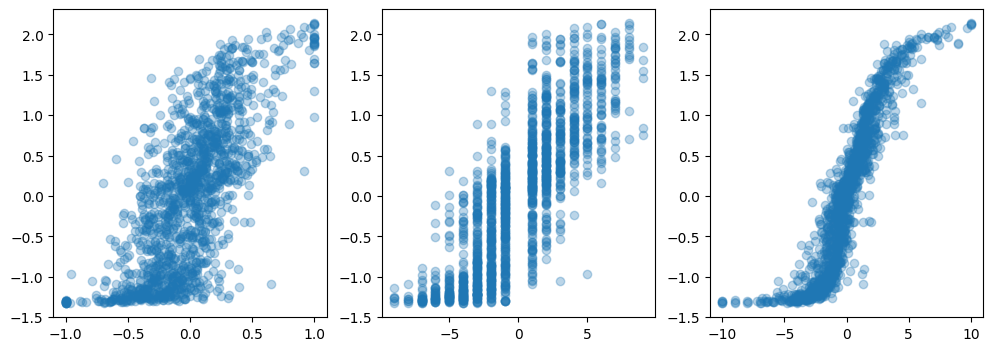

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

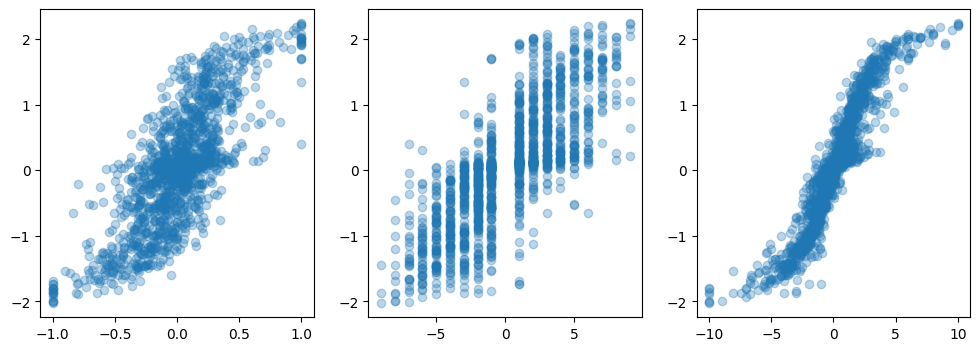

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


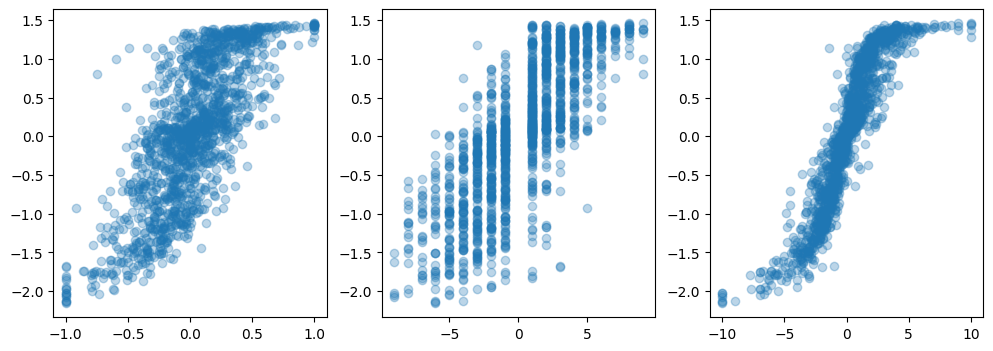

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);